# Separation speech block
_Author: Bart van Erp_ 

_Date:   2-02-2022_

This notebook contains the verification experiments to the paper **Model-Based Source Separation Using Invertible Neural Networks**.

## Load packages

In [1]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [2]:
# load data
data_train_signal = Data("../../../../data/train/processed/" .* readdir("../../../../data/train/processed"), Float64)
data_test_signal = Data("../../../../data/test/processed/" .* readdir("../../../../data/test/processed"), Float64);

In [3]:
# generate data if it does not exist yet
if !isdir("data")

    # create folders
    mkdir("data")
    mkdir("data/train")
    mkdir("data/test")
    mkdir("data/train/noise")
    mkdir("data/test/noise")
    mkdir("data/test/mix")

    # generate offsets and amps
    start_noise  = 10*randn(length(data_train_signal) + length(data_test_signal))
    start_mix    = 10*randn(length(data_train_signal) + length(data_test_signal))
    amps         = 5*rand(length(data_train_signal) + length(data_test_signal))

    # generate train data
    for k = 1:length(data_train_signal)
        t = collect(1:length(data_train_signal[k]))./16000
        h5write(string("data/train/noise/",  lpad(k,4,"0"), ".h5"), "signal", amps[k]* sign.(cos.(start_noise[k].+2*π*3000*collect(t))))
    end

    # generate test data
    for k = 1:length(data_test_signal)
        ki = k + length(data_train_signal)
        t = collect(1:length(data_test_signal[k]))./16000
        h5write(string("data/test/noise/",  lpad(k,4,"0"), ".h5"), "signal", amps[ki] .* sign.(cos.(start_mix[ki].+2*π*3000*collect(t))))
        h5write(string("data/test/mix/",    lpad(k,4,"0"), ".h5"), "signal", data_test_signal[k] .+ amps[ki] .* sign.(cos.(start_mix[ki].+2*π*3000*collect(t))))
    end

end

In [4]:
# load data
data_train_noise = Data("data/train/noise/" .* readdir("data/train/noise"), Float64)
data_test_noise  = Data("data/test/noise/"  .* readdir("data/test/noise"),  Float64)
data_test_mix    = Data("data/test/mix/"    .* readdir("data/test/mix"),    Float64)

Data{Float64, String}(["data/test/mix/0001.h5", "data/test/mix/0002.h5", "data/test/mix/0003.h5", "data/test/mix/0004.h5", "data/test/mix/0005.h5", "data/test/mix/0006.h5", "data/test/mix/0007.h5", "data/test/mix/0008.h5", "data/test/mix/0009.h5", "data/test/mix/0010.h5", "data/test/mix/0011.h5"])

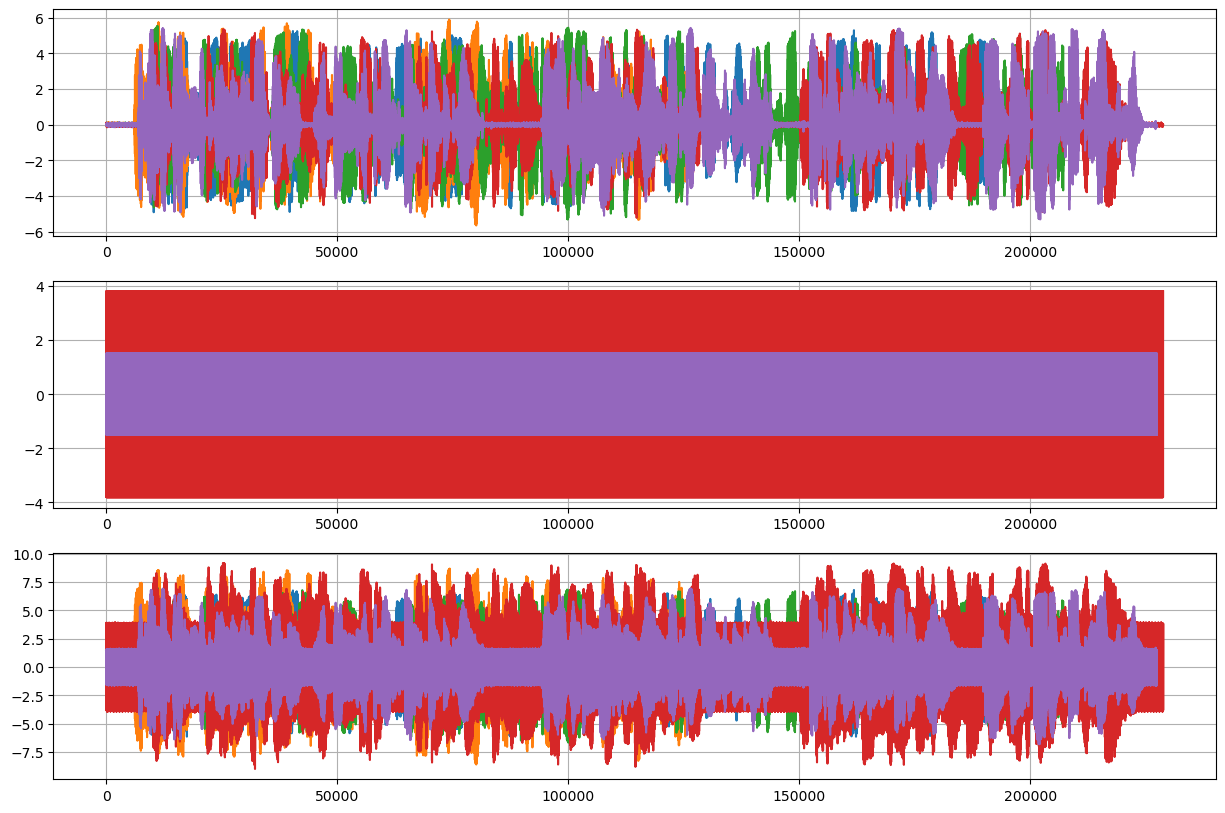

In [5]:
_, ax = plt.subplots(figsize=(15,10), nrows=3)
for k in 1:5
    ax[1].plot(data_test_signal[k])
    ax[2].plot(data_test_noise[k])
    ax[3].plot(data_test_mix[k])
end
 ax[1].grid(), ax[2].grid(), ax[3].grid();

## Train models

In [6]:
function create_ar_model(dim; shift=1, batch_size::Int=128)

    return Model(
        dim,
        (
            ARLayer(
                dim,
                Model(  
                    dim-shift,
                    shift,
                    (   
                        DenseLayer(dim-shift, shift; batch_size=batch_size),
                    );
                    batch_size=batch_size
                );
                batch_size=batch_size
            ),
        );
        batch_size=batch_size
    )
        
end
batch_size = 128
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
loss_function_noise  = MSE(batch_size=batch_size)
;

In [7]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_ar_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_signal, 1e-5)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_train_signal,      # train data
        data_test_signal,       # test data
        10,                     # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

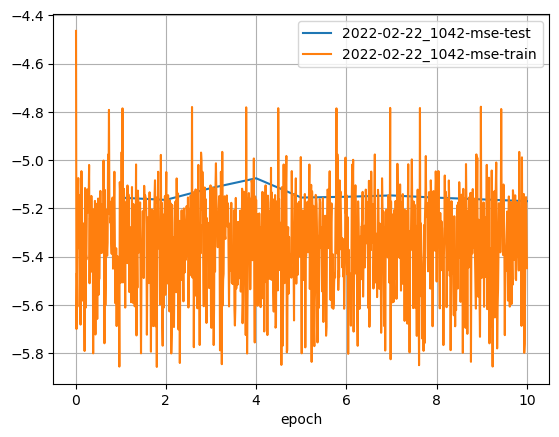

In [8]:
plot_logs(; path="logs/signal/", logscale=true);

In [9]:
# load/train noise model
if isdir("logs/noise")

    # load model
    model_noise = load(string("logs/noise/", readdir("logs/noise")[1], "/model.jld2"))["model"]

else

    # create model
    model_noise = create_ar_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_noise, 1e-5)

    # create train suite
    train_suite_noise = TrainSuite(
        model_noise,           # model
        loss_function_noise,   # loss function
        data_train_noise,      # train data
        data_test_noise,       # test data
        1,                    # number of epochs
        "logs/noise/"          # path to log directory
    );

    # create folder
    mkdir("logs/noise")

    # train model
    run!(train_suite_noise)

end;

epoch 001: 100%|████████████████████████████████████████| Time: 0:04:23
  mse_train:  3.6613865564861034e-5
  mse_test:   6.230244860897917e-7


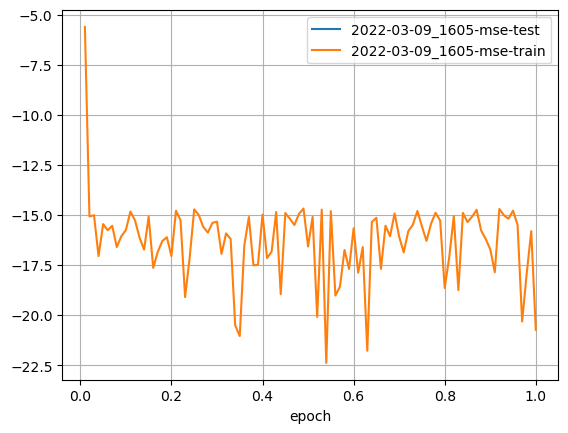

In [10]:
plot_logs(; path="logs/noise/", logscale=true);

## Kalman priors

In [17]:
H = zeros(2*dim_in)
H[1] = 1
H[1+dim_in] = 1

Q = zeros(2*dim_in, 2*dim_in)
R = 1e-10
Q[1,1] = 0.0057 * dim_in # exp(-5.5) * dim_in
Q[1+dim_in, 1+dim_in] = 6.23e-7 * dim_in # exp(-5.5) * dim_in

signal_mix = data_test_mix[1]

m_x_prior = randn(2*dim_in)
# m_x_prior = vcat(data_mix_signal[1][16:-1:1], data_mix_noise[1][16:-1:1])
V_x_prior = 1e2*diagm(ones(2*dim_in));
# V_x_prior = 1e-1*diagm(ones(2*dim_in));

## Extended Kalman filter/smoother

In [18]:
function EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q; dim_in=16)

    # allocate output
    m_x_f = Vector{Vector{Float64}}(undef,length(signal_mix))
    V_x_f = Vector{Matrix{Float64}}(undef,length(signal_mix))

    # copy priors
    m_x = copy(m_x_prior)
    V_x = copy(V_x_prior)

    # kalman filtering
    for k in dim_in+1:length(signal_mix)
    
        # predict step
        m_x_new = vcat(forward(model_signal, m_x[1:dim_in]), forward(model_noise, m_x[dim_in+1:end]))
        F = vcat(hcat(jacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), jacobian(model_noise, m_x[dim_in+1:end])))
        V_x_new = F*V_x*F' + Q
    
        # filtering messages
        y = signal_mix[k] - dot(H, m_x_new)
        S = dot(H, V_x_new, H) + R
        K = V_x_new * H * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H')*V_x_new
    
        # save values
        m_x_f[k] = copy(m_x)
        V_x_f[k] = copy(V_x)
    
    end

    # copy output
    m_x_new = copy(m_x_f[end])
    V_x_new = copy(V_x_f[end])

    m_signal_filtering = [m_x_f[k][1]                       for k = dim_in+1:length(signal_mix)]
    V_signal_filtering = [V_x_f[k][1,1]                     for k = dim_in+1:length(signal_mix)]
    m_noise_filtering  = [m_x_f[k][1+dim_in]                for k = dim_in+1:length(signal_mix)]
    V_noise_filtering  = [V_x_f[k][1+dim_in,1+dim_in]       for k = dim_in+1:length(signal_mix)]

    # return output
    m_signal_filtering, V_signal_filtering, m_noise_filtering, V_noise_filtering
    
end

EKF (generic function with 1 method)

In [19]:
m_signal_filtering, V_signal_filtering, m_noise_filtering, V_noise_filtering  = EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q);

#### Filtering distribution

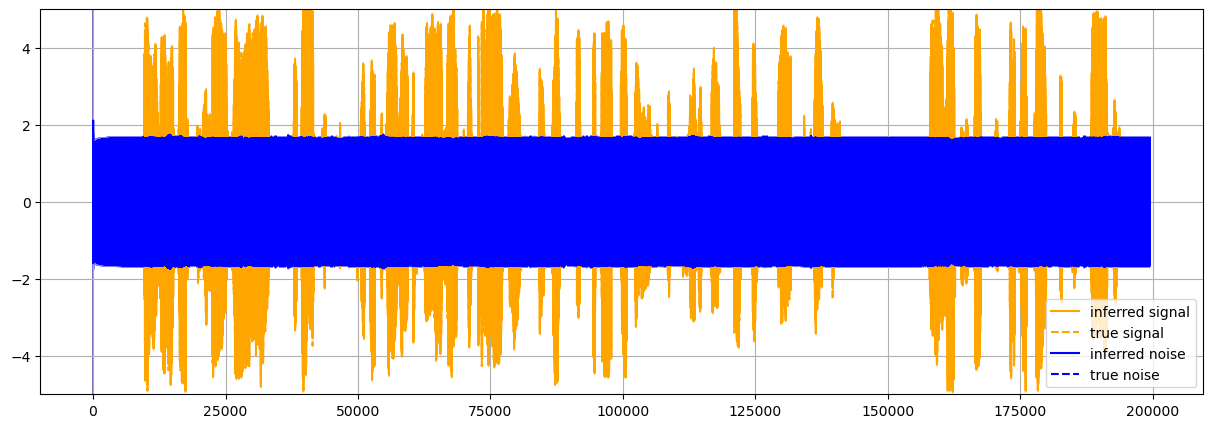

In [22]:
plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:length(data_test_signal[1]), m_signal_filtering+sqrt.(V_signal_filtering), m_signal_filtering-sqrt.(V_signal_filtering), color="orange", alpha=0.5)
plt.plot(dim_in+1:length(data_test_signal[1]), m_signal_filtering, color="orange", label="inferred signal")
plt.plot(1:length(data_test_signal[1]), data_test_signal[1], color="orange", linestyle="--", label="true signal")
plt.fill_between(dim_in+1:length(data_test_signal[1]), m_noise_filtering+sqrt.(V_noise_filtering), m_noise_filtering-sqrt.(V_noise_filtering), color="blue", alpha=0.5)
plt.plot(dim_in+1:length(data_test_signal[1]), m_noise_filtering, color="blue", label="inferred noise")
plt.plot(1:length(data_test_signal[1]), data_test_noise[1], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-5,5)
# plt.xlim(0,10000);

In [21]:
10*log10(mean(abs2.(data_test_signal[1])) / mean(abs2.(data_test_signal[1] .- signal_mix))),
10*log10(mean(abs2.(data_test_signal[1][1+dim_in:end])) / mean(abs2.(data_test_signal[1][1+dim_in:end] .- m_signal_filtering)))

(-3.4753129188733656, 14.545339957187679)

In [16]:
break

LoadError: syntax: break or continue outside loop

#### metrics

In [ ]:
MSE_filtering  = Vector{Float64}(undef, length(data_mix))
MSE_smoothing  = Vector{Float64}(undef, length(data_mix))
MAE_filtering  = Vector{Float64}(undef, length(data_mix))
MAE_smoothing  = Vector{Float64}(undef, length(data_mix))
logp_filtering = Vector{Float64}(undef, length(data_mix))
logp_smoothing = Vector{Float64}(undef, length(data_mix))

for (ind, signal_mix) in enumerate(data_mix)

    # run EKF
    m_signal_filtering, V_signal_filtering, m_signal_smoothing, V_signal_smoothing, m_noise_filtering, V_noise_filtering, m_noise_smoothing, V_noise_smoothing = EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q);

    # calculate metrics
    MSE_filtering[ind]  = sum(abs2.(m_signal_filtering .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_filtering)
    MSE_smoothing[ind]  = sum(abs2.(m_signal_smoothing .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_smoothing)
    MAE_filtering[ind]  = sum(abs.(m_signal_filtering .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_filtering)
    MAE_smoothing[ind]  = sum(abs.(m_signal_smoothing .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_smoothing)
    logp_filtering[ind] = sum([logpdf(Normal(m_signal_filtering[k], sqrt(V_signal_filtering[k])), data_mix_signal[ind][k+dim_in]) for k=1:length(m_signal_filtering)])/length(m_signal_filtering)
    logp_smoothing[ind] = sum([logpdf(Normal(m_signal_smoothing[k], sqrt(V_signal_smoothing[k])), data_mix_signal[ind][k+dim_in]) for k=1:length(m_signal_smoothing)])/length(m_signal_smoothing)

end

In [ ]:
mean(MSE_filtering), mean(MSE_smoothing), mean(MAE_filtering), mean(MAE_smoothing), mean(logp_filtering), mean(logp_smoothing)

## Worst situation (filtering)

In [ ]:
m_signal_filtering, V_signal_filtering, m_signal_smoothing, V_signal_smoothing, m_noise_filtering, V_noise_filtering, m_noise_smoothing, V_noise_smoothing = EKF(data_mix[2], model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q);

In [ ]:
plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:length(data_signal[2]), m_signal_filtering+sqrt.(V_signal_filtering), m_signal_filtering-sqrt.(V_signal_filtering), color="orange", alpha=0.5)
plt.plot(dim_in+1:length(data_signal[2]), m_signal_filtering, color="orange", label="inferred signal")
plt.plot(1:length(data_signal[2]), data_mix_signal[2], color="orange", linestyle="--", label="true signal")
plt.fill_between(dim_in+1:length(data_signal[2]), m_noise_filtering+sqrt.(V_noise_filtering), m_noise_filtering-sqrt.(V_noise_filtering), color="blue", alpha=0.5)
plt.plot(dim_in+1:length(data_signal[2]), m_noise_filtering, color="blue", label="inferred noise")
plt.plot(1:length(data_signal[2]), data_mix_noise[2], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-5,5)
plt.xlim(0,1000);